In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
plt.style.use("ggplot")

%matplotlib inline

## Split-Apply-Combine

One powerful paradigm for analyzing data is the "Split-Apply-Combine" strategy

This strategy has three steps:

1. `Split`: split the data into groups based on values
2. `Apply`: apply a function or routine to each group separately
3. `Combine`: combine the output of the apply step into a DataFrame, using the group identifiers as the index

We will cover the main components in this lecture, but we encourage you to also study the [official documentation](https://pandas.pydata.org/pandas-docs/stable/groupby.html) to learn more about what is possible

To describe the concepts, we will need some data

We will begin with a simple made-up dataset to discuss the concepts and then work through extended example and exercises with real data

In [2]:
bball = pd.DataFrame({
    "Year": [2015, 2016, 2017]*2,
    "Player": ["Curry"]*3 + ["Durant"]*3,
    "Team": ["GSW"]*3 + ["OKC"] + ["GSW"]*2,
    "Pts": [30.1, 25.3, 27.1, 28.2, 25.1, 25.9],
    "Assist": [6.7, 6.6, 6.4, 5.0, 4.8, 5.3],
    "Rebound": [4.5, 3.9, 3.4, 4.4, 6.5, 7.6]
})

bball.info()
bball

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
Assist     6 non-null float64
Player     6 non-null object
Pts        6 non-null float64
Rebound    6 non-null float64
Team       6 non-null object
Year       6 non-null int64
dtypes: float64(3), int64(1), object(2)
memory usage: 368.0+ bytes


,Assist,Player,Pts,Rebound,Team,Year
0,6.7,Curry,30.1,4.5,GSW,2015
1,6.6,Curry,25.3,3.9,GSW,2016
2,6.4,Curry,27.1,3.4,GSW,2017
3,5.0,Durant,28.2,4.4,OKC,2015
4,4.8,Durant,25.1,6.5,GSW,2016
5,5.3,Durant,25.9,7.6,GSW,2017


### Simple example

To perform the **_SPLIT_** step, we call the `groupby` method on our DataFrame

The first argument to `groupby` is a description of how we want to construct groups

In the most basic version we will pass a string identifying the column name

In [3]:
gbA = bball.groupby("Team")

The `type` of variable we get back is a `DataFrameGroupBy`, which we will sometimes refer to as GroupBy for short. The command below shows the groups that we have access to.

In [4]:
gbA.groups

{'GSW': Int64Index([0, 1, 2, 4, 5], dtype='int64'),
 'OKC': Int64Index([3], dtype='int64')}

Then this is a way to grab one of the groups...

In [5]:
gbA.get_group("OKC")

,Assist,Player,Pts,Rebound,Team,Year
3,5.0,Durant,28.2,4.4,OKC,2015


We can **_APPLY_** some of our favorite reduction functions directly on the `GroupBy` object

**Exercise**: With your neighbor, look closely at the output of the cells below

How did pandas compute the sum of `gbA`? What happened to the `NaN` entries in column `C`?

Hint: try `gbA.count()` or `gbA.mean()` if you can't decide what happened to the `NaN`s

In [6]:
gbA.mean()

,Assist,Pts,Rebound,Year
Team,,,,
GSW,5.96,26.7,5.18,2016.2
OKC,5.00,28.2,4.40,2015.0


**Exercise**: Use (tab completion) to see what other reductions are defined for GroupBy objects

Pick three and evaluate them in the cells below

Does the output of each of these commands have the same features as the output of `gbA.sum()` from above? If not, what is different?

You can also apply on only one column, e.g. we just want the mean of B, by group.

In [7]:
gbA["Pts"].mean()

Team
GSW    26.7
OKC    28.2
Name: Pts, dtype: float64

One final thing, we can apply an aggregation by column using a dictionary. 

In [8]:
transform_dict = {"Pts": "sum", "Year": "first"}


gbA.agg(transform_dict)

,Pts,Year
Team,,
GSW,133.5,2015
OKC,28.2,2015


If we pass a list of strings to `groupby`, it will group based on unique combinations of values from all columns in the list

Let's see an example

In [10]:
gbAB = bball.groupby(["Team", "Player"])
type(gbAB)

pandas.core.groupby.DataFrameGroupBy

In [11]:
gbAB.groups

{('GSW', 'Curry'): Int64Index([0, 1, 2], dtype='int64'),
 ('GSW', 'Durant'): Int64Index([4, 5], dtype='int64'),
 ('OKC', 'Durant'): Int64Index([3], dtype='int64')}

In [13]:
#gbAB.get_group((1,1)).Pts.mean()

gbAB.get_group(("OKC","Durant")).Pts.mean()

28.2

### "Not reductions": the `apply` method

We can apply "not reductions" to DataFrames. Here is the idea, is we want to grab a subset of the series by group, apply and operation, then recombine everything in a new DataFrame. How is this different than what we were doing above? In the stuff above, the resulting output always had length of the number of groups. So when we grouped by team, the length was two. Now we may want a situation in which the output is not "reduced" to the number of groups, but more general.  

Lets explore some examples. We can do the same with GroupBy objects using the `.apply` method

Let's see an example

In [14]:
def best_by_pts(df):
    return df.nlargest(2, "Pts")

In [16]:
gbA = bball.groupby("Player")

new_df = gbA.apply(best_by_pts)

new_df

Assist  Player   Pts  Rebound Team  Year
Player                                            
Curry  0     6.7   Curry  30.1      4.5  GSW  2015
       2     6.4   Curry  27.1      3.4  GSW  2017
Durant 3     5.0  Durant  28.2      4.4  OKC  2015
       5     5.3  Durant  25.9      7.6  GSW  2017

First, talk through what is going on here. First, it split the DataFrame by player. Next, it found the two best years in terms of points (this is the `best_by_pts` function), this is the apply step. **Here is the deal** the output from the apply step is of length 2 (for the two best years) width of however many columns their are. Then it combines the two DataFrames into one larger one. 

Why you you want to do this? This is telling us something about player specific outcomes by first spliting, then applying and selecting them, and then by combining them we can compare...what was Curry's best year, what team was he on vs Durant's best years and what team was he on. 

on theInteresting, for both players, 2016 was the relativly weak year. Do you see what is going on here?

**Exercise**: This exercise has a few steps:

1. Write a function that, given a DataFrame, creates a new column that computes each players points as a deviation from career mean, and then the function returns the entire DataFrame
2. Apply the function to `bball`
3. With your neighbor describe what happened?

In [19]:
def mean_dev_by_pts(df):
    df["mean_dev"] = df["Pts"] - df["Pts"].mean()
    return df

In [20]:
gbA = bball.groupby("Player")

gbA.apply(mean_dev_by_pts)

,Assist,Player,Pts,Rebound,Team,Year,mean_dev
0,6.7,Curry,30.1,4.5,GSW,2015,2.6
1,6.6,Curry,25.3,3.9,GSW,2016,-2.2
2,6.4,Curry,27.1,3.4,GSW,2017,-0.4
3,5.0,Durant,28.2,4.4,OKC,2015,1.8
4,4.8,Durant,25.1,6.5,GSW,2016,-1.3
5,5.3,Durant,25.9,7.6,GSW,2017,-0.5


Again, think about what is going on here. First, it split the DataFrame by player. Next, for each player it computed the difference in points between **that players career  average** and his season average (this is the `mean_dev_by_pts` function), this is the apply step. **Here is the deal** the output from the apply step is of length 3 (as this is for all the years) width of however many columns their are. Then it combines the two DataFrames into one larger one. 

In other words, what we did is just added a column, but we computed the column by taking the points relative to the **group specific mean**. This is the key value added of this approach. 

---

### `pd.Grouper`

Sometimes in order to construct the groups you want, you need to give pandas more information than just a column name

Some examples are:

- Grouping by a column and a level of the index
- Grouping time series data at a particular frequency

Pandas lets you do this through the `pd.Grouper` type. Lets continue to explore this with **more** basketball data...Below is individual player box score data from 2016-2017 season. I found this on Kaggle [here](https://www.kaggle.com/pablote/nba-enhanced-stats/data)

In [23]:
pgame = pd.read_csv("https://github.com/mwaugh0328/data_bootcamp_spring_2018/raw/master/data/2016-17_playerBoxScore.csv")

In [38]:
pgame.teamLoc

0        Away
1        Away
2        Away
3        Away
4        Away
5        Away
6        Away
7        Away
8        Away
9        Away
10       Away
11       Away
12       Away
13       Home
14       Home
15       Home
16       Home
17       Home
18       Home
19       Home
20       Home
21       Home
22       Home
23       Home
24       Home
25       Home
26       Away
27       Away
28       Away
29       Away
         ... 
26115    Home
26116    Home
26117    Home
26118    Home
26119    Home
26120    Home
26121    Home
26122    Home
26123    Home
26124    Home
26125    Home
26126    Away
26127    Away
26128    Away
26129    Away
26130    Away
26131    Away
26132    Away
26133    Away
26134    Away
26135    Away
26136    Away
26137    Home
26138    Home
26139    Home
26140    Home
26141    Home
26142    Home
26143    Home
26144    Home
Name: teamLoc, Length: 26145, dtype: object

Now when we look at `gmDate` column this tells us the date. The issue is that we want (and we can have) pandas recognize it as a date. This will be important as this will allow for abunch of functionality that we would not have other wise. Below we do this...

In [29]:
pgame["gmDate"] = pd.to_datetime(pgame["gmDate"], format="%Y-%m-%d")
# This last operation converts the gm

#pgame.info()

Now lets just look at Kevin Durant through the year. Let's also make sure there are not multiple Durant's in the dataset...

In [36]:
pgame.playLNm.value_counts()["Durant"]

62

In [37]:
durant_game = pgame[pgame.playLNm == "Durant"]

**The WANT** is the group by Durant's performance over the year. We could do 2016 vs. 2017...by month, by week, etc. Now how do we do this, well the pd.Grouper helps us group on dates in a very easy way. 

In [44]:
durant_game.groupby([pd.Grouper(key="gmDate", freq="M")]).count()

,gmTime,seasTyp,playLNm,playFNm,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,teamDayOff,...,playFT%,playORB,playDRB,playTRB,opptAbbr,opptConf,opptDiv,opptLoc,opptRslt,opptDayOff
gmDate,,,,,,,,,,,,,,,,,,,,,
2016-10-31,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2016-11-30,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
2016-12-31,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
2017-01-31,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
2017-02-28,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
2017-03-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-04-30,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


Lets look at this as home versus away... 

In [46]:
durant_game.groupby([pd.Grouper(key="gmDate", freq="M"), "teamLoc"]).mean()

teamDayOff    playMin  playHeight  playWeight    playPTS  \
gmDate     teamLoc                                                             
2016-10-31 Away       1.500000  38.500000        81.0       225.0  33.500000   
           Home       0.000000  37.000000        81.0       225.0  27.000000   
2016-11-30 Away       1.500000  32.625000        81.0       225.0  24.250000   
           Home       2.000000  35.000000        81.0       225.0  28.428571   
2016-12-31 Away       1.000000  34.625000        81.0       225.0  25.125000   
           Home       2.375000  33.125000        81.0       225.0  23.875000   
2017-01-31 Away       1.166667  34.666667        81.0       225.0  28.000000   
           Home       2.375000  34.375000        81.0       225.0  26.875000   
2017-02-28 Away       1.285714  29.428571        81.0       225.0  20.857143   
           Home       4.250000  32.500000        81.0       225.0  21.500000   
2017-04-30 Home       2.333333  30.333333        81.0       225.0  20.333333   

                     playAST    playTO   playSTL   playBLK    playPF  \
gmDate     teamLoc                                                     
2016-10-31 Away     5.000000  3.000000  3.000000  1.500000  2.000000   
           Home     4.000000  0.000000  2.000000  2.000000  2.000000   
2016-11-30 Away     5.375000  1.750000  2.000000  1.250000  2.375000   
           Home     4.000000  3.000000  0.571429  2.000000  1.857143   
2016-12-31 Away     4.125000  1.750000  0.875000  1.000000  2.500000   
           Home     5.500000  2.875000  0.625000  2.000000  1.750000   
2017-01-31 Away     5.000000  3.000000  1.166667  2.166667  1.833333   
           Home     4.375000  2.000000  1.000000  2.000000  1.375000   
2017-02-28 Away     4.000000  2.142857  0.571429  1.285714  1.857143   
           Home     7.250000  1.500000  1.500000  1.500000  1.250000   
2017-04-30 Home     5.666667  1.666667  0.666667  0.666667  1.666667   

                       ...       play3PA   play3PM   play3P%    playFTA  \
gmDate     teamLoc     ...                                                
2016-10-31 Away        ...      3.500000  1.000000  0.250000  14.000000   
           Home        ...      3.000000  1.000000  0.333300   5.000000   
2016-11-30 Away        ...      4.750000  1.875000  0.343750   5.875000   
           Home        ...      5.428571  2.857143  0.491586   5.571429   
2016-12-31 Away        ...      5.000000  1.625000  0.344938   7.125000   
           Home        ...      4.750000  1.750000  0.390637   6.125000   
2017-01-31 Away        ...      5.500000  1.333333  0.272817   6.500000   
           Home        ...      5.750000  2.625000  0.452238   5.750000   
2017-02-28 Away        ...      4.857143  1.571429  0.276529   7.142857   
           Home        ...      4.750000  1.750000  0.389900   3.000000   
2017-04-30 Home        ...      5.333333  1.666667  0.238100   4.000000   

                      playFTM   playFT%   playORB    playDRB    playTRB  \
gmDate     teamLoc                                                        
2016-10-31 Away     13.500000  0.968750  0.000000  10.500000  10.500000   
           Home      4.000000  0.800000  0.000000  10.000000  10.000000   
2016-11-30 Away      4.375000  0.752375  1.000000   6.625000   7.625000   
           Home      5.000000  0.871429  0.857143   7.571429   8.428571   
2016-12-31 Away      6.250000  0.852963  0.125000   8.500000   8.625000   
           Home      5.375000  0.727087  0.625000   9.750000  10.375000   
2017-01-31 Away      6.000000  0.924333  0.500000   6.500000   7.000000   
           Home      5.000000  0.702775  0.875000   6.250000   7.125000   
2017-02-28 Away      6.428571  0.793129  0.714286   5.428571   6.142857   
           Home      2.750000  0.708325  0.750000   9.250000  10.000000   
2017-04-30 Home      3.333333  0.833333  0.333333   9.000000   9.333333   

                    opptDayOff  
gmDate     teamLoc              
2016-10-31 Away       1.

Just to practice...lets plot some of this stuff

[Text(0,0,'Oct'),
 Text(0,0,'Nov'),
 Text(0,0,'Dec'),
 Text(0,0,'Jan'),
 Text(0,0,'Feb'),
 Text(0,0,'Mar'),
 Text(0,0,'Apr')]

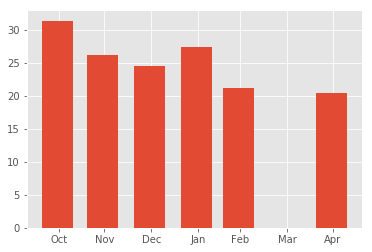

In [61]:
df = durant_game.groupby([pd.Grouper(key="gmDate", freq="M")]).mean()

months = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr"]

fix, ax = plt.subplots()

ax.bar(df.index, df.playPTS, width = 20.5)

ax.set_xticklabels(months)

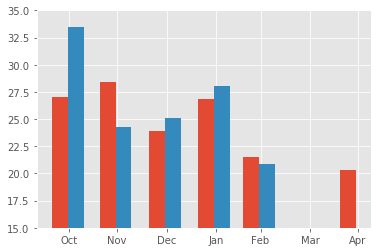

In [94]:
df = durant_game.groupby(["teamLoc", pd.Grouper(key="gmDate", freq="M")]).mean()

width = 10

fix, ax = plt.subplots()

ax.bar(df.loc["Home"].index - datetime.timedelta(5), df.loc["Home"].playPTS, width)

ax.bar(df.loc["Away"].index + datetime.timedelta(5), df.loc["Away"].playPTS, width)

ax.set_xticklabels(months)

ax.set_ylim(15,35)

plt.show()

In [85]:
df.loc["Away"].index + datetime.timedelta(10)

DatetimeIndex(['2016-11-10', '2016-12-10', '2017-01-10', '2017-02-10',
               '2017-03-10'],
              dtype='datetime64[ns]', name='gmDate', freq=None)